In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [7]:
from fastai import *
from fastai.vision import *

# Download data set

In [3]:
help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url: str, fname: Union[pathlib.Path, str] = None, dest: Union[pathlib.Path, str] = None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if it doesn't exist, and un-tgz to folder `dest`.



In [5]:
# Download the data and return a Python pathlib.Path object
# https://docs.python.org/3/library/pathlib.html
path = untar_data(URLs.PETS)
path

PosixPath('/home/paperspace/.fastai/data/oxford-iiit-pet')

In [6]:
path.ls()

[PosixPath('/home/paperspace/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/home/paperspace/.fastai/data/oxford-iiit-pet/annotations')]

In [8]:
anno = path/'annotations'
img = path/'images'

In [9]:
help(get_image_files)

Help on function get_image_files in module fastai.vision.data:

get_image_files(c: Union[pathlib.Path, str], check_ext: bool = True, recurse=False) -> Collection[pathlib.Path]
    Return list of files in `c` that are images. `check_ext` will filter to `image_extensions`.



In [15]:
fnames = get_image_files(img)
fnames[:5]

[PosixPath('/home/paperspace/.fastai/data/oxford-iiit-pet/images/Bombay_70.jpg'),
 PosixPath('/home/paperspace/.fastai/data/oxford-iiit-pet/images/pug_169.jpg'),
 PosixPath('/home/paperspace/.fastai/data/oxford-iiit-pet/images/Ragdoll_96.jpg'),
 PosixPath('/home/paperspace/.fastai/data/oxford-iiit-pet/images/boxer_43.jpg'),
 PosixPath('/home/paperspace/.fastai/data/oxford-iiit-pet/images/scottish_terrier_4.jpg')]

In [16]:
# Create vars for the image collection factory below

# Set the seed
np.random.seed(2)

# Create the regex to pull out the label from the image file name
regex = r'/([^/]+)_\d+.jpg$'

In [23]:
# Load the images into a DataBunch object using a factory method

# For more info:
# help(DataBunch)
# help(ImageDataBunch)
# ?get_transforms
# ?imagenet_stats

data = ImageDataBunch.from_name_re(path, fnames, regex, ds_tfms = get_transforms(), size = 224)
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList
y: CategoryList (5912 items)
[Category Bombay, Category pug, Category Ragdoll, Category wheaten_terrier, Category Sphynx]...
Path: /home/paperspace/.fastai/data/oxford-iiit-pet
x: ImageItemList (5912 items)
[Image (3, 103, 137), Image (3, 300, 256), Image (3, 375, 500), Image (3, 333, 500), Image (3, 374, 500)]...
Path: /home/paperspace/.fastai/data/oxford-iiit-pet;

Valid: LabelList
y: CategoryList (1478 items)
[Category boxer, Category german_shorthaired, Category Maine_Coon, Category samoyed, Category japanese_chin]...
Path: /home/paperspace/.fastai/data/oxford-iiit-pet
x: ImageItemList (1478 items)
[Image (3, 375, 500), Image (3, 500, 333), Image (3, 500, 375), Image (3, 500, 425), Image (3, 500, 409)]...
Path: /home/paperspace/.fastai/data/oxford-iiit-pet;

Test: None

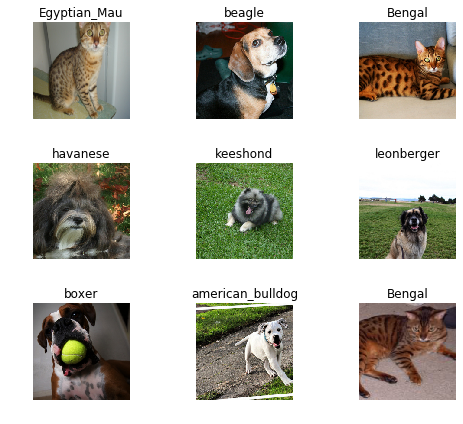

In [26]:
data.show_batch(rows = 3, figsize = (7,6))

# Examine the data

In [27]:
# Labels
print(data.classes)

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


In [28]:
# Number of labels
print(data.c)

37


# Train the model - resnet34

In [30]:
# Create the CNN learner object
# help(create_cnn)

learn = create_cnn(data, models.resnet34, metrics = error_rate)

In [31]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate
1,1.416692,0.328260,0.095399
2,0.580232,0.245838,0.077131
3,0.360947,0.209685,0.064953
4,0.264383,0.194530,0.060893


In [32]:
learn.save('pets_stage_1')

# Training results

In [34]:
# help(ClassificationInterpretation)

out = ClassificationInterpretation.from_learner(learn)

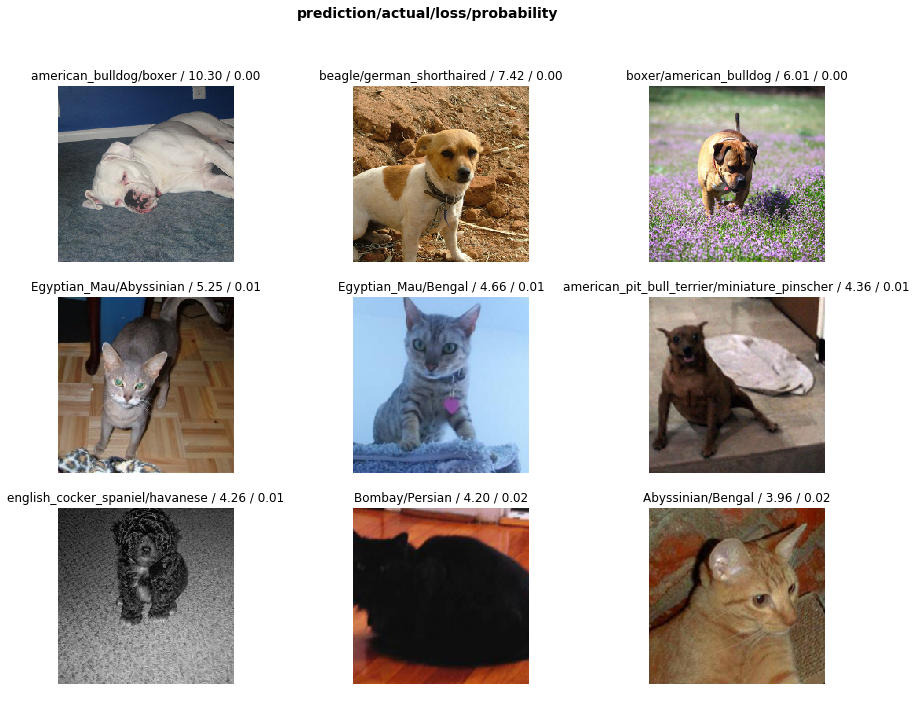

In [40]:
# Which items did we get most wrong?
# help(ClassificationInterpretation.plot_top_losses)
# doc(ClassificationInterpretation.plot_top_losses)

out.plot_top_losses(9, figsize = (15,11))

In [41]:
# What did we get wrong most often?
out.most_confused(min_val = 2)

[('Birman', 'Ragdoll', 6),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 6),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 6),
 ('chihuahua', 'miniature_pinscher', 4),
 ('British_Shorthair', 'Russian_Blue', 3),
 ('Persian', 'Ragdoll', 3),
 ('Ragdoll', 'Birman', 3),
 ('american_bulldog', 'boxer', 3),
 ('miniature_pinscher', 'american_pit_bull_terrier', 3)]

# Continue training

In [42]:
# Find optimal learning rate
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


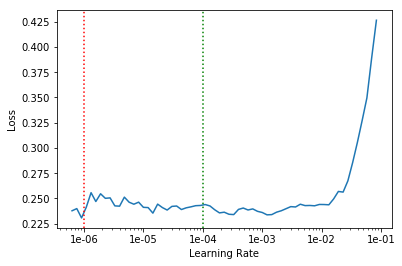

In [43]:
learn.recorder.plot()
plt.axvline(1e-6, color = 'r', linestyle = ':')
plt.axvline(1e-4, color = 'g', linestyle = ':')

We know that the earlier layers of the model were assigned weights via transfer learning, and these weights were already tuned for the kinds of images in the dataset. As a consequence the earlier layers won't benefit from a higher learning rate.  However, we also saw that the later layers responded well to a higher learning rate.  In order to support this a range of learning rates will be passed to the model for the next round of training.  The range will contain smaller learning rates for the earlier layers of the model, and higher learning rates for the last layers of the model.

In [45]:
learn.load('pets_stage_1')

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (5912 items)
[Category Bombay, Category pug, Category Ragdoll, Category wheaten_terrier, Category Sphynx]...
Path: /home/paperspace/.fastai/data/oxford-iiit-pet
x: ImageItemList (5912 items)
[Image (3, 103, 137), Image (3, 300, 256), Image (3, 375, 500), Image (3, 333, 500), Image (3, 374, 500)]...
Path: /home/paperspace/.fastai/data/oxford-iiit-pet;

Valid: LabelList
y: CategoryList (1478 items)
[Category boxer, Category german_shorthaired, Category Maine_Coon, Category samoyed, Category japanese_chin]...
Path: /home/paperspace/.fastai/data/oxford-iiit-pet
x: ImageItemList (1478 items)
[Image (3, 375, 500), Image (3, 500, 333), Image (3, 500, 375), Image (3, 500, 425), Image (3, 500, 409)]...
Path: /home/paperspace/.fastai/data/oxford-iiit-pet;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=

In [46]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr = slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate
1,0.225225,0.192719,0.056834
2,0.221287,0.186931,0.062246
3,0.200821,0.180262,0.056157
4,0.182871,0.180183,0.057510


In [47]:
learn.save('pets_stage_2')

# Train the model - resnet50

In [49]:
# Create the CNN learner object
# help(create_cnn)

learn = create_cnn(data, models.resnet50, metrics = error_rate)

In [50]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate
1,0.872923,0.288908,0.091340
2,0.415644,0.234980,0.077131
3,0.257479,0.179803,0.060217
4,0.171029,0.168731,0.053451


In [54]:
learn.save('pets_stage_1_resnet50')

# Continue training

In [55]:
# Find optimal learning rate
%time learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


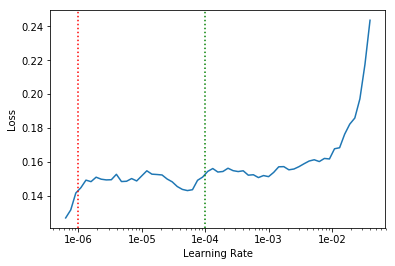

In [56]:
learn.recorder.plot()
plt.axvline(1e-6, color = 'r', linestyle = ':')
plt.axvline(1e-4, color = 'g', linestyle = ':')

In [ ]:
learn.unfreeze()
%time learn.fit_one_cycle(4, max_lr = slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate
1,0.143342,0.165692,0.053451
2,0.147653,0.160016,0.054127
3,0.123399,0.157445,0.048038


In [ ]:
learn.save('pets_stage_2_resnet50')